In [1]:
import json
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# File to analyze
filename = "finetune_evals/random_letter_ECT_1000_2025-12-05-05-28-29_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_random_letters_PopMC_0_difficulty_filtered_test_all_tests_n1000_detailed.jsonl"

In [2]:
def calculate_entropy_from_log_probs(log_probs_dict):
    """
    Calculate entropy from log probabilities using: entropy = -sum(p * log(p))
    where p = softmax(log_probs)
    
    Args:
        log_probs_dict: Dictionary with keys A, B, C, D and log probability values
        
    Returns:
        Entropy value (float)
    """
    # Extract log probabilities in order A, B, C, D
    log_probs = np.array([log_probs_dict.get(letter, -np.inf) for letter in ['A', 'B', 'C', 'D']])
    
    # Handle -inf values (set to very negative number)
    log_probs = np.where(log_probs == -np.inf, -1e10, log_probs)
    
    # Compute softmax to get probabilities
    # Subtract max for numerical stability
    log_probs_shifted = log_probs - np.max(log_probs)
    exp_log_probs = np.exp(log_probs_shifted)
    probs = exp_log_probs / np.sum(exp_log_probs)
    
    # Calculate entropy: -sum(p * log(p))
    # Use log2 for entropy in bits, or natural log
    # Using natural log here to match standard entropy definition
    entropy = -np.sum(probs * np.log(probs + 1e-10))  # Add small epsilon to avoid log(0)
    
    return entropy

# Test the function
test_log_probs = {"A": -1.0, "B": -2.0, "C": -3.0, "D": -4.0}
test_entropy = calculate_entropy_from_log_probs(test_log_probs)
print(f"Test entropy: {test_entropy:.4f}")


Test entropy: 0.9475


In [3]:
def load_jsonl_data(filepath):
    """
    Load JSONL file and return list of records.
    
    Args:
        filepath: Path to JSONL file
        
    Returns:
        List of dictionaries, one per line
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping invalid JSON line: {e}")
    return data

# Load the data
print(f"Loading data from: {filename}")
data = load_jsonl_data(filename)
print(f"Loaded {len(data)} records")

# Check if model_type field exists in data
if 'model_type' in data[0]:
    model_types = set([record.get('model_type', 'unknown') for record in data])
    print(f"Model types found in data: {sorted(model_types)}")
    print(f"  Base model records: {sum(1 for r in data if r.get('model_type') == 'base')}")
    print(f"  Finetuned model records: {sum(1 for r in data if r.get('model_type') == 'finetuned')}")
else:
    print("Warning: No 'model_type' field found in data. Using filename inference.")
    def infer_model_type(filename):
        filename_str = str(filename)
        if 'llm_metacognition' in filename_str and 'step-' in filename_str:
            return 'finetuned'
        else:
            return 'base'
    model_type = infer_model_type(filename)
    print(f"Inferred model type: {model_type}")

# Check conditions present
conditions = set([record.get('condition', 'Unknown') for record in data])
print(f"\nConditions found: {sorted(conditions)}")


Loading data from: finetune_evals/random_letter_ECT_1000_2025-12-05-05-28-29_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_random_letters_PopMC_0_difficulty_filtered_test_all_tests_n1000_detailed.jsonl
Loaded 8000 records
Model types found in data: ['base', 'finetuned']
  Base model records: 4000
  Finetuned model records: 4000

Conditions found: ['Both Normal', 'Both Random', 'MCQ Normal, Confidence Random', 'MCQ Random, Confidence Normal']


In [4]:
# Process data: calculate entropy and extract confidence
processed_data = []

for record in data:
    condition = record.get('condition', 'Unknown')
    mcq_log_probs = record.get('mcq', {}).get('log_probs', {})
    confidence = record.get('confidence', {}).get('predicted_confidence', None)
    
    # Get model type from data if available, otherwise infer from filename
    if 'model_type' in record:
        model_type = record.get('model_type', 'unknown')
    else:
        # Fallback to filename inference if model_type field doesn't exist
        filename_str = str(filename)
        if 'llm_metacognition' in filename_str and 'step-' in filename_str:
            model_type = 'finetuned'
        else:
            model_type = 'base'
    
    # Skip if missing required data
    if not mcq_log_probs or confidence is None:
        continue
    
    # Calculate entropy
    entropy = calculate_entropy_from_log_probs(mcq_log_probs)
    
    processed_data.append({
        'condition': condition,
        'model_type': model_type,
        'entropy': entropy,
        'confidence': confidence,
        'qid': record.get('qid', ''),
    })

print(f"Processed {len(processed_data)} records with valid data")
print(f"\nBreakdown by model type:")
df_temp = pd.DataFrame(processed_data)
if 'model_type' in df_temp.columns:
    print(df_temp['model_type'].value_counts().to_string())
print(f"\nSample record:")
print(f"  Condition: {processed_data[0]['condition']}")
print(f"  Model type: {processed_data[0].get('model_type', 'N/A')}")
print(f"  Entropy: {processed_data[0]['entropy']:.4f}")
print(f"  Confidence: {processed_data[0]['confidence']:.2f}")


Processed 8000 records with valid data

Breakdown by model type:
model_type
base         4000
finetuned    4000

Sample record:
  Condition: Both Normal
  Model type: base
  Entropy: 0.0362
  Confidence: 44.04


In [5]:
def bootstrap_correlation(x, y, n_bootstrap=1000, confidence_level=0.95):
    """
    Calculate bootstrap confidence interval for Pearson correlation.
    
    Args:
        x: First variable
        y: Second variable
        n_bootstrap: Number of bootstrap samples
        confidence_level: Confidence level (default 0.95 for 95% CI)
        
    Returns:
        (correlation, lower_bound, upper_bound)
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    
    # Original correlation
    corr, _ = pearsonr(x, y)
    
    # Bootstrap samples
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n, size=n, replace=True)
        x_boot = x[indices]
        y_boot = y[indices]
        
        # Calculate correlation for bootstrap sample
        try:
            corr_boot, _ = pearsonr(x_boot, y_boot)
            if not np.isnan(corr_boot):
                bootstrap_corrs.append(corr_boot)
        except:
            continue
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_corrs, 100 * alpha / 2)
    upper = np.percentile(bootstrap_corrs, 100 * (1 - alpha / 2))
    
    return corr, lower, upper

# Calculate correlations for each condition and model type combination
df = pd.DataFrame(processed_data)

results = []

# Group by both condition and model_type
for condition in sorted(df['condition'].unique()):
    for model_type in sorted(df['model_type'].unique()):
        condition_data = df[(df['condition'] == condition) & (df['model_type'] == model_type)]
        
        if len(condition_data) < 2:
            print(f"Warning: Not enough data for condition '{condition}' and model '{model_type}'")
            continue
        
        x = condition_data['entropy'].values
        y = condition_data['confidence'].values
        
        # Calculate correlation with p-value
        corr, p_value = pearsonr(x, y)
        
        # Calculate bootstrap confidence interval
        corr_boot, lower_ci, upper_ci = bootstrap_correlation(x, y, n_bootstrap=1000)
        
        n = len(condition_data)
        
        results.append({
            'condition': condition,
            'model_type': model_type,
            'correlation': corr,
            'p_value': p_value,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'n_samples': n,
        })
        
        print(f"\n{condition} ({model_type}):")
        print(f"  Correlation: {corr:.4f}")
        print(f"  P-value: {p_value:.4e}")
        print(f"  95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]")
        print(f"  Sample size: {n}")

results_df = pd.DataFrame(results)
print(f"\n{'='*60}")
print("Summary Statistics")
print(f"{'='*60}")
print(results_df.to_string(index=False))



Both Normal (base):
  Correlation: -0.4594
  P-value: 2.3344e-53
  95% CI: [-0.5148, -0.4072]
  Sample size: 1000

Both Normal (finetuned):
  Correlation: -0.8015
  P-value: 4.4637e-225
  95% CI: [-0.8232, -0.7760]
  Sample size: 1000

Both Random (base):
  Correlation: -0.1632
  P-value: 2.1187e-07
  95% CI: [-0.2258, -0.0919]
  Sample size: 1000

Both Random (finetuned):
  Correlation: -0.5583
  P-value: 5.1726e-83
  95% CI: [-0.6042, -0.5075]
  Sample size: 1000

MCQ Normal, Confidence Random (base):
  Correlation: -0.3296
  P-value: 8.9990e-27
  95% CI: [-0.3869, -0.2684]
  Sample size: 1000

MCQ Normal, Confidence Random (finetuned):
  Correlation: -0.6885
  P-value: 2.0919e-141
  95% CI: [-0.7219, -0.6540]
  Sample size: 1000

MCQ Random, Confidence Normal (base):
  Correlation: -0.2998
  P-value: 3.2835e-22
  95% CI: [-0.3628, -0.2370]
  Sample size: 1000

MCQ Random, Confidence Normal (finetuned):
  Correlation: -0.6735
  P-value: 3.7515e-133
  95% CI: [-0.7110, -0.6324]
  Sam


✓ Saved figure to: entropy_confidence_correlation.png


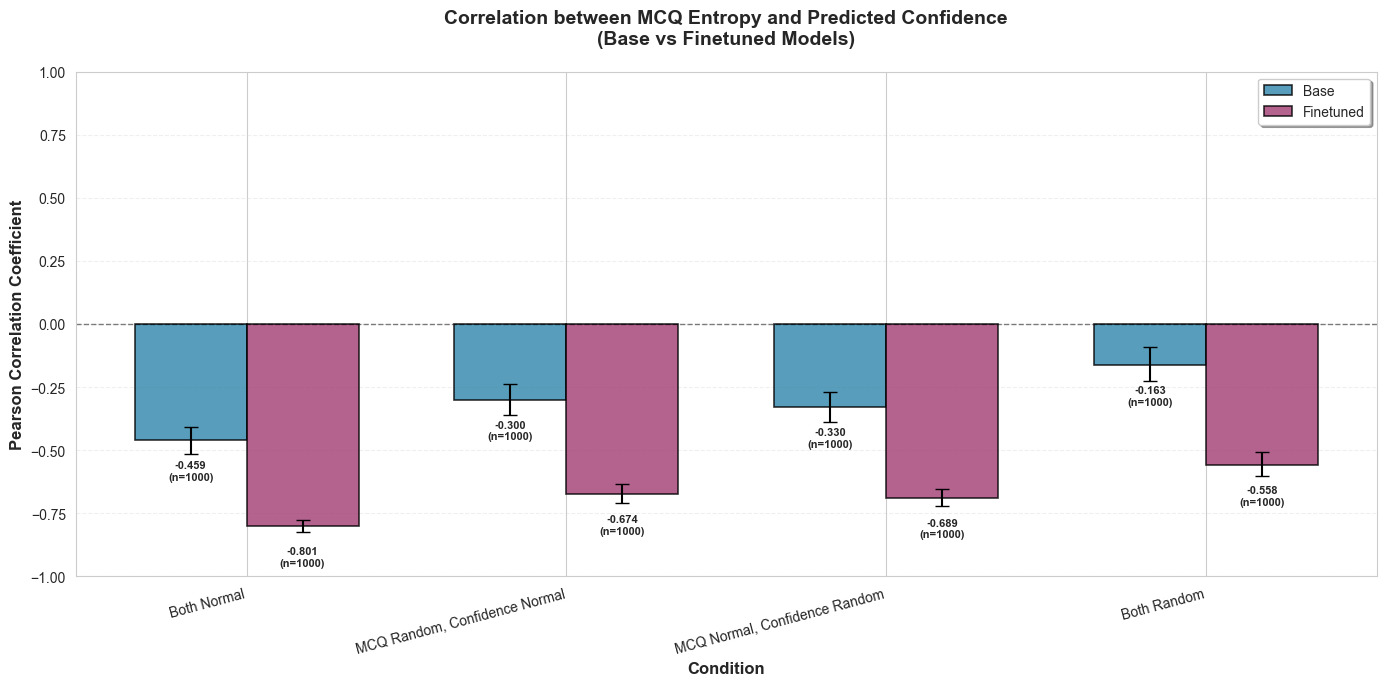

In [6]:
# Create grouped bar chart visualization
# This will show base and finetuned results side by side for each condition

# Define condition order for consistent plotting
condition_order = [
    'Both Normal',
    'MCQ Random, Confidence Normal',
    'MCQ Normal, Confidence Random',
    'Both Random'
]

# Filter to only conditions we have data for
available_conditions = [c for c in condition_order if c in results_df['condition'].values]

# Check if we have both base and finetuned data
model_types_in_data = set(results_df['model_type'].unique())
has_both_models = len(model_types_in_data) > 1

# Set up plot
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(available_conditions))
width = 0.35  # Width of bars

colors = {'base': '#2E86AB', 'finetuned': '#A23B72'}

# Plot bars for each model type
for i, model_type in enumerate(['base', 'finetuned']):
    if model_type not in model_types_in_data:
        continue
    
    model_data = results_df[results_df['model_type'] == model_type]
    
    # Sort by condition order
    model_data['condition_cat'] = pd.Categorical(
        model_data['condition'],
        categories=available_conditions,
        ordered=True
    )
    model_data = model_data.sort_values('condition_cat')
    
    # Calculate positions (offset for grouped bars)
    offset = (i - 0.5) * width
    positions = x_pos + offset
    
    # Get values
    correlations = model_data['correlation'].values
    lower_cis = model_data['lower_ci'].values
    upper_cis = model_data['upper_ci'].values
    n_samples = model_data['n_samples'].values
    
    # Plot bars
    bars = ax.bar(
        positions,
        correlations,
        width=width,
        yerr=[
            correlations - lower_cis,
            upper_cis - correlations
        ],
        capsize=5,
        color=colors[model_type],
        label=model_type.capitalize(),
        alpha=0.8,
        edgecolor='black',
        linewidth=1.2
    )
    
    # Add value labels
    for bar, corr, n in zip(bars, correlations, n_samples):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + (0.05 if height >= 0 else -0.08),
            f'{corr:.3f}\n(n={n})',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=8,
            fontweight='bold'
        )

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Customize plot
ax.set_xlabel('Condition', fontweight='bold')
ax.set_ylabel('Pearson Correlation Coefficient', fontweight='bold')
if has_both_models:
    ax.set_title('Correlation between MCQ Entropy and Predicted Confidence\n(Base vs Finetuned Models)', 
                 fontweight='bold', pad=20)
else:
    ax.set_title('Correlation between MCQ Entropy and Predicted Confidence', 
                 fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(available_conditions, rotation=15, ha='right')
ax.set_ylim([-1, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('entropy_confidence_correlation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved figure to: entropy_confidence_correlation.png")
plt.show()


In [7]:
# This cell is no longer needed since we now extract model_type from the data itself
# The main analysis above already handles both base and finetuned models from a single file

print("Note: The current implementation extracts model_type from the data field.")
print("If you have separate files for base and finetuned models, you can still combine them:")
print("")
print("# Example for combining multiple files:")
print("filepaths = [")
print("    'path/to/base_model_file.jsonl',")
print("    'path/to/finetuned_model_file.jsonl'")
print("]")
print("all_data = []")
print("for filepath in filepaths:")
print("    all_data.extend(load_jsonl_data(filepath))")
print("# Then use 'all_data' instead of 'data' in the processing cells above")


Note: The current implementation extracts model_type from the data field.
If you have separate files for base and finetuned models, you can still combine them:

# Example for combining multiple files:
filepaths = [
    'path/to/base_model_file.jsonl',
    'path/to/finetuned_model_file.jsonl'
]
all_data = []
for filepath in filepaths:
    all_data.extend(load_jsonl_data(filepath))
# Then use 'all_data' instead of 'data' in the processing cells above


In [8]:
# This function is now integrated into the main visualization cell above
# The grouped bar chart is automatically created when both base and finetuned data are present

print("The grouped bar chart is now automatically generated in the visualization cell above.")
print("It will show base and finetuned results side by side for each condition.")


The grouped bar chart is now automatically generated in the visualization cell above.
It will show base and finetuned results side by side for each condition.


In [9]:
# ============================================================================
# MAIN ANALYSIS SUMMARY
# ============================================================================
# The analysis above automatically processes both base and finetuned models
# from the single file (which contains both model types with the 'model_type' field).
# Results are displayed side by side in the grouped bar chart.

print("="*60)
print("Analysis Complete")
print("="*60)
print(f"\nTotal records processed: {len(processed_data)}")
print(f"Conditions analyzed: {len(results_df['condition'].unique())}")
print(f"Model types: {sorted(results_df['model_type'].unique())}")
print(f"\nResults summary:")
print(results_df.to_string(index=False))
print("\n✓ Visualization saved to: entropy_confidence_correlation.png")


Analysis Complete

Total records processed: 8000
Conditions analyzed: 4
Model types: ['base', 'finetuned']

Results summary:
                    condition model_type  correlation       p_value  lower_ci  upper_ci  n_samples
                  Both Normal       base    -0.459394  2.334420e-53 -0.514761 -0.407212       1000
                  Both Normal  finetuned    -0.801492 4.463749e-225 -0.823221 -0.776041       1000
                  Both Random       base    -0.163181  2.118691e-07 -0.225839 -0.091912       1000
                  Both Random  finetuned    -0.558278  5.172597e-83 -0.604170 -0.507502       1000
MCQ Normal, Confidence Random       base    -0.329625  8.999032e-27 -0.386861 -0.268386       1000
MCQ Normal, Confidence Random  finetuned    -0.688503 2.091931e-141 -0.721888 -0.653976       1000
MCQ Random, Confidence Normal       base    -0.299766  3.283495e-22 -0.362790 -0.236985       1000
MCQ Random, Confidence Normal  finetuned    -0.673530 3.751453e-133 -0.710966 -0.63

In [10]:
# Extract letter selections for histograms
# We need to get the actual letters selected for MCQ and confidence

def extract_selected_letters(record):
    """
    Extract the actual letter selected by the model for MCQ and confidence.
    Returns (mcq_letter, conf_letter) or (None, None) if data is missing.
    
    Note: The letter_mapping dictionaries map: original_letter -> display_letter
    So {A: X, B: Y} means original A maps to display X, original B maps to display Y
    """
    mcq_letter = None
    conf_letter = None
    
    # Extract MCQ letter
    mcq_data = record.get('mcq', {})
    if 'predicted_letter_display' in mcq_data:
        # This is the actual letter the model saw/selected (could be A-Z)
        mcq_letter = mcq_data['predicted_letter_display']
    elif 'predicted_letter' in mcq_data:
        # Check if MCQ letters are randomized
        mcq_letter_mapping = record.get('mcq_letter_mapping', None)
        if mcq_letter_mapping:
            # mcq_letter_mapping maps: original_letter (A-D) -> display_letter (random)
            # We have predicted_letter (A-D), need to get display_letter
            # So: display_letter = mcq_letter_mapping[predicted_letter]
            mcq_letter = mcq_letter_mapping.get(mcq_data['predicted_letter'], mcq_data['predicted_letter'])
        else:
            # Not randomized, so predicted_letter is the actual letter
            mcq_letter = mcq_data['predicted_letter']
    
    # Extract confidence letter
    conf_data = record.get('confidence', {})
    if 'predicted_bin' in conf_data:
        conf_bin = conf_data['predicted_bin']
        
        # Check if confidence letters are randomized
        conf_letter_mapping = record.get('conf_letter_mapping', None)
        if conf_letter_mapping:
            # conf_letter_mapping maps: original_letter (A-H) -> display_letter (random)
            # We have predicted_bin (A-H), need to get display_letter
            # So: display_letter = conf_letter_mapping[predicted_bin]
            conf_letter = conf_letter_mapping.get(conf_bin, conf_bin)
        else:
            # Not randomized, so bin letter is the actual letter
            conf_letter = conf_bin
    
    return mcq_letter, conf_letter

# Debug: Check a few records to see the mapping structure
print("Checking mapping structure in data...")
samples_by_condition = {}
for record in data:
    condition = record.get('condition', 'Unknown')
    if condition not in samples_by_condition:
        samples_by_condition[condition] = record
    if len(samples_by_condition) >= 4:
        break

for condition, sample in samples_by_condition.items():
    print(f"\n{'='*60}")
    print(f"Sample record: {condition}")
    print(f"{'='*60}")
    if 'mcq_letter_mapping' in sample:
        print(f"  MCQ mapping: {sample['mcq_letter_mapping']}")
        print(f"  MCQ predicted_letter (original): {sample.get('mcq', {}).get('predicted_letter', 'N/A')}")
        print(f"  MCQ predicted_letter_display: {sample.get('mcq', {}).get('predicted_letter_display', 'N/A')}")
        # Verify mapping
        pred_orig = sample.get('mcq', {}).get('predicted_letter', None)
        if pred_orig and pred_orig in sample['mcq_letter_mapping']:
            expected_display = sample['mcq_letter_mapping'][pred_orig]
            actual_display = sample.get('mcq', {}).get('predicted_letter_display', None)
            print(f"  → Expected display letter: {expected_display}, Actual: {actual_display}")
            if expected_display != actual_display:
                print(f"  ⚠️  MISMATCH!")
    else:
        print(f"  MCQ: No mapping (normal A-D)")
        print(f"  MCQ predicted_letter: {sample.get('mcq', {}).get('predicted_letter', 'N/A')}")
        print(f"  MCQ predicted_letter_display: {sample.get('mcq', {}).get('predicted_letter_display', 'N/A')}")
    
    if 'conf_letter_mapping' in sample:
        print(f"  Conf mapping: {sample['conf_letter_mapping']}")
        print(f"  Conf predicted_bin (original): {sample.get('confidence', {}).get('predicted_bin', 'N/A')}")
        # Verify mapping
        pred_bin = sample.get('confidence', {}).get('predicted_bin', None)
        if pred_bin and pred_bin in sample['conf_letter_mapping']:
            expected_display = sample['conf_letter_mapping'][pred_bin]
            print(f"  → Expected display letter: {expected_display}")
    else:
        print(f"  Conf: No mapping (normal A-H)")
        print(f"  Conf predicted_bin: {sample.get('confidence', {}).get('predicted_bin', 'N/A')}")
    print()

# Process all records to extract letters
letter_data = []
for record in data:
    condition = record.get('condition', 'Unknown')
    model_type = record.get('model_type', 'unknown')
    
    mcq_letter, conf_letter = extract_selected_letters(record)
    
    if mcq_letter:
        letter_data.append({
            'condition': condition,
            'model_type': model_type,
            'type': 'MCQ',
            'letter': mcq_letter
        })
    
    if conf_letter:
        letter_data.append({
            'condition': condition,
            'model_type': model_type,
            'type': 'Confidence',
            'letter': conf_letter
        })

letter_df = pd.DataFrame(letter_data)
print(f"Extracted {len(letter_data)} letter selections")
print(f"\nSample data:")
print(letter_df.head(10))
print(f"\nUnique letters found: {sorted(letter_df['letter'].unique())}")

# Debug: Show letter distributions by condition and type
print("\n" + "="*80)
print("Letter distributions by condition and type:")
print("="*80)
print("\nEXPECTED BEHAVIOR:")
print("  - Normal MCQ: A-D only")
print("  - Random MCQ: Any letters A-Z (randomly selected)")
print("  - Normal Confidence: A-H only")
print("  - Random Confidence: Any letters A-Z (randomly selected)")
print("\n" + "="*80)

for condition in sorted(letter_df['condition'].unique()):
    for model_type in sorted(letter_df['model_type'].unique()):
        for data_type in ['MCQ', 'Confidence']:
            subset = letter_df[
                (letter_df['condition'] == condition) &
                (letter_df['model_type'] == model_type) &
                (letter_df['type'] == data_type)
            ]
            if len(subset) > 0:
                letter_counts = subset['letter'].value_counts().sort_index()
                unique_letters = sorted(subset['letter'].unique())
                
                # Check for unexpected letters based on condition
                is_random_mcq = ('MCQ Random' in condition or 'Both Random' in condition)
                is_random_conf = ('Confidence Random' in condition or 'Both Random' in condition)
                
                unexpected = []
                if data_type == 'MCQ':
                    if is_random_mcq:
                        # Random MCQ can have any letters A-Z, but should have more than just A-D
                        # (if it only has A-D, that's suspicious)
                        if set(unique_letters).issubset(set('ABCD')):
                            unexpected = ['Only A-D found (should be random from A-Z)']
                    else:
                        # Normal MCQ should ONLY have A-D
                        unexpected = [l for l in unique_letters if l not in 'ABCD']
                elif data_type == 'Confidence':
                    if is_random_conf:
                        # Random Confidence can have any letters A-Z, but should have more than just A-H
                        # (if it only has A-H, that's suspicious)
                        if set(unique_letters).issubset(set('ABCDEFGH')):
                            unexpected = ['Only A-H found (should be random from A-Z)']
                    else:
                        # Normal Confidence should ONLY have A-H
                        unexpected = [l for l in unique_letters if l not in 'ABCDEFGH']
                
                print(f"\n{condition} | {model_type} | {data_type}:")
                print(f"  Unique letters ({len(unique_letters)}): {unique_letters}")
                if unexpected:
                    print(f"  ⚠️  UNEXPECTED LETTERS: {unexpected}")
                print(f"  Top 5: {dict(letter_counts.head(5))}")


Checking mapping structure in data...

Sample record: Both Normal
  MCQ: No mapping (normal A-D)
  MCQ predicted_letter: A
  MCQ predicted_letter_display: A
  Conf: No mapping (normal A-H)
  Conf predicted_bin: C


Sample record: MCQ Random, Confidence Normal
  MCQ mapping: {'A': 'M', 'B': 'E', 'C': 'Y', 'D': 'H'}
  MCQ predicted_letter (original): A
  MCQ predicted_letter_display: M
  → Expected display letter: M, Actual: M
  Conf: No mapping (normal A-H)
  Conf predicted_bin: F


Sample record: MCQ Normal, Confidence Random
  MCQ: No mapping (normal A-D)
  MCQ predicted_letter: A
  MCQ predicted_letter_display: A
  Conf mapping: {'A': 'V', 'B': 'J', 'C': 'N', 'D': 'U', 'E': 'P', 'F': 'Q', 'G': 'L', 'H': 'K'}
  Conf predicted_bin (original): D
  → Expected display letter: U


Sample record: Both Random
  MCQ mapping: {'A': 'M', 'B': 'E', 'C': 'Y', 'D': 'H'}
  MCQ predicted_letter (original): A
  MCQ predicted_letter_display: M
  → Expected display letter: M, Actual: M
  Conf mapping: 

\n✓ Saved figure to: letter_selection_histograms.png


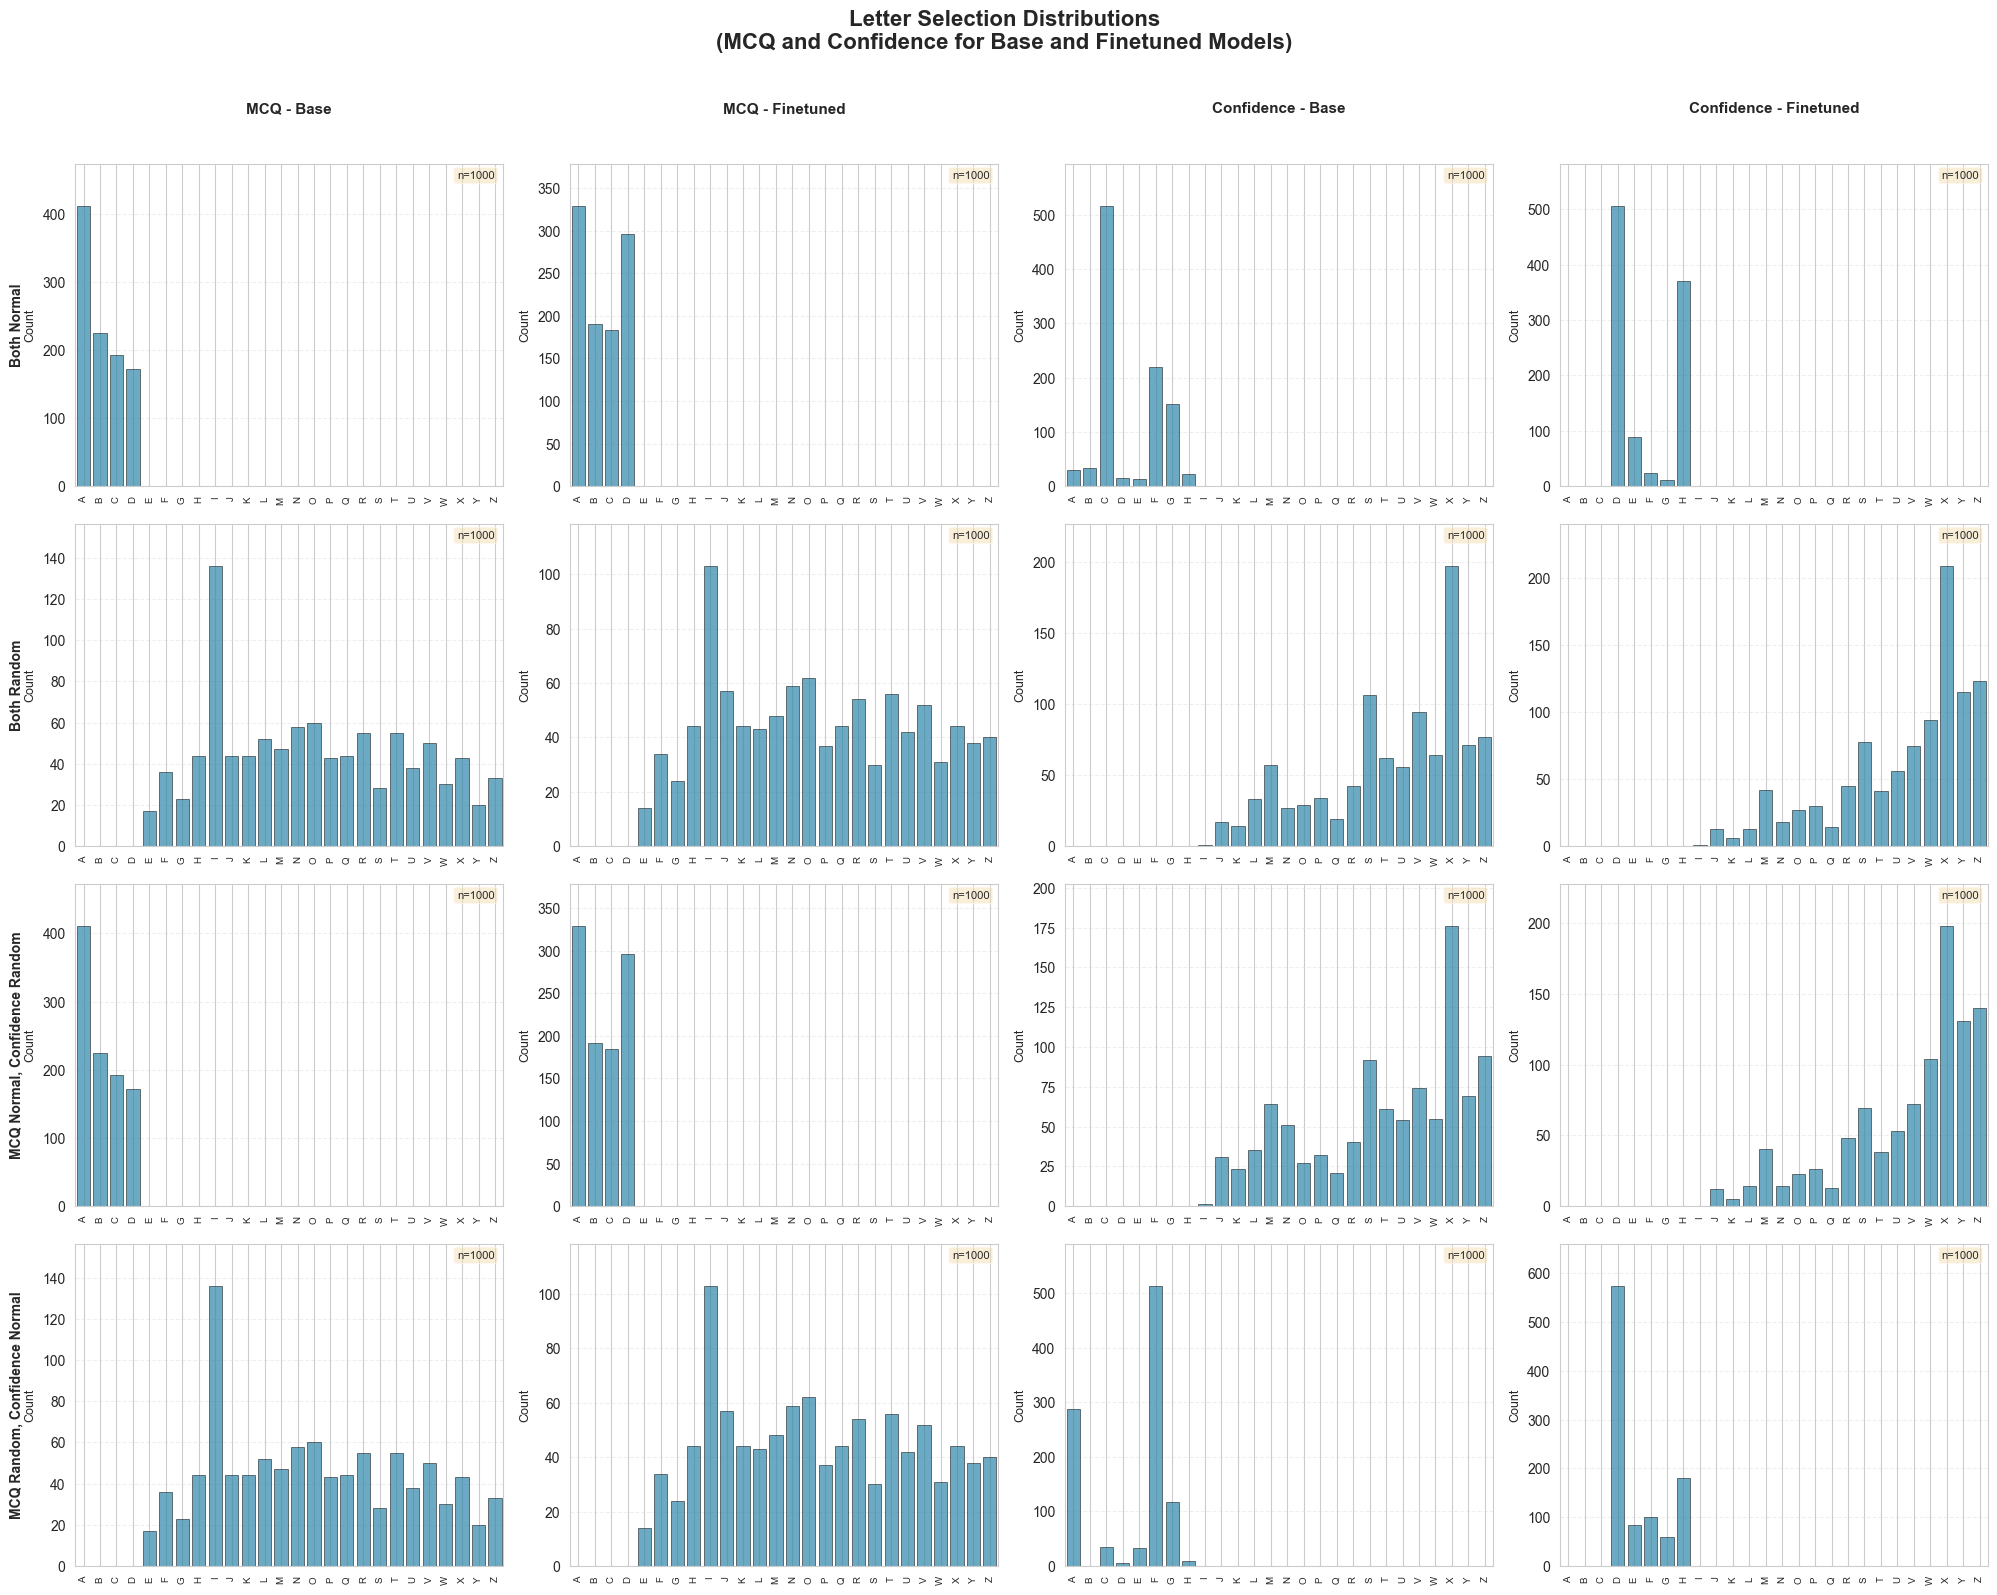

In [11]:
# Create 16 histograms (2 types × 2 models × 4 conditions)
# Layout: 4 rows (conditions) × 4 columns (MCQ-base, MCQ-finetuned, Conf-base, Conf-finetuned)

# Define all 26 letters
all_letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]

# Get unique conditions and model types
conditions = sorted(letter_df['condition'].unique())
model_types = sorted(letter_df['model_type'].unique())
types = ['MCQ', 'Confidence']

# Create figure with subplots: 4 rows (conditions) × 4 columns
# Column order: MCQ-base, MCQ-finetuned, Conf-base, Conf-finetuned
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Letter Selection Distributions\n(MCQ and Confidence for Base and Finetuned Models)', 
             fontsize=16, fontweight='bold', y=0.995)

# Column labels
col_labels = ['MCQ - Base', 'MCQ - Finetuned', 'Confidence - Base', 'Confidence - Finetuned']
for col_idx, label in enumerate(col_labels):
    axes[0, col_idx].text(0.5, 1.15, label, 
                         transform=axes[0, col_idx].transAxes,
                         ha='center', va='bottom', fontsize=11, fontweight='bold')

for row_idx, condition in enumerate(conditions):
    # Column 0: MCQ - Base
    # Column 1: MCQ - Finetuned
    # Column 2: Confidence - Base
    # Column 3: Confidence - Finetuned
    
    for col_idx, (model_type, data_type) in enumerate([
        ('base', 'MCQ'),
        ('finetuned', 'MCQ'),
        ('base', 'Confidence'),
        ('finetuned', 'Confidence')
    ]):
        ax = axes[row_idx, col_idx]
        
        # Filter data
        subset = letter_df[
            (letter_df['condition'] == condition) &
            (letter_df['model_type'] == model_type) &
            (letter_df['type'] == data_type)
        ]
        
        if len(subset) > 0:
            # Count letter frequencies
            letter_counts = subset['letter'].value_counts().sort_index()
            
            # Create full series with all 26 letters (fill missing with 0)
            full_counts = pd.Series(index=all_letters, data=0)
            full_counts.update(letter_counts)
            
            # Create bar plot
            bars = ax.bar(range(26), full_counts.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Set x-axis labels
            ax.set_xticks(range(26))
            ax.set_xticklabels(all_letters, rotation=90, fontsize=7)
            ax.set_xlim(-0.5, 25.5)
            
            # Set y-axis
            max_count = full_counts.max()
            if max_count > 0:
                ax.set_ylim(0, max_count * 1.15)
            ax.set_ylabel('Count', fontsize=9)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            # Add condition label (only on first column)
            if col_idx == 0:
                ax.text(-0.12, 0.5, condition, 
                       transform=ax.transAxes, 
                       ha='right', va='center',
                       fontsize=10, fontweight='bold', rotation=90)
            
            # Add total count
            total = len(subset)
            ax.text(0.98, 0.98, f'n={total}', 
                   transform=ax.transAxes, 
                   ha='right', va='top',
                   fontsize=8, 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            # No data for this combination
            ax.text(0.5, 0.5, 'No data', 
                   transform=ax.transAxes, 
                   ha='center', va='center',
                   fontsize=12, style='italic')
            ax.set_xticks([])
            ax.set_yticks([])
            if col_idx == 0:
                ax.text(-0.12, 0.5, condition, 
                       transform=ax.transAxes, 
                       ha='right', va='center',
                       fontsize=10, fontweight='bold', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('letter_selection_histograms.png', dpi=300, bbox_inches='tight')
print("\\n✓ Saved figure to: letter_selection_histograms.png")
plt.show()
